# Tarea 2

In [46]:
# Import necessary libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

# For visualization
import seaborn as sns


## Load and Preprocess Images:

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


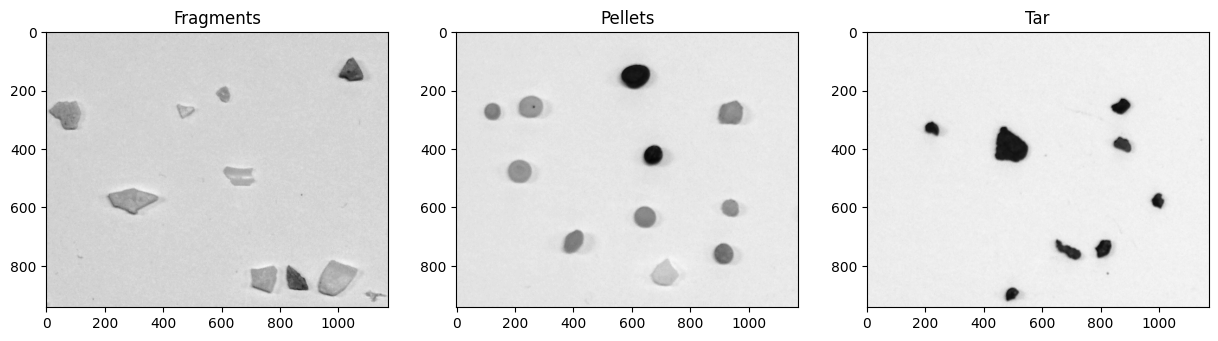

In [82]:
# Load the images 
img_fragments = cv2.imread('FRA.png')
img_pellets = cv2.imread('PEL.png')
img_tar = cv2.imread('TAR.png')

# Convert images to grayscale
gray_fragments = cv2.cvtColor(img_fragments, cv2.COLOR_BGR2GRAY)
gray_pellets = cv2.cvtColor(img_pellets, cv2.COLOR_BGR2GRAY)
gray_tar = cv2.cvtColor(img_tar, cv2.COLOR_BGR2GRAY)


In [194]:
# Gaussian Blur to reduce noise and improve thresholding
blur_fragments = cv2.GaussianBlur(gray_fragments, (3, 3), sigmaX=0)
blur_pellets = cv2.GaussianBlur(gray_pellets, (3, 3), sigmaX=0)
blur_tar = cv2.GaussianBlur(gray_tar, (3, 3), sigmaX=0)

### Thresholding and Inversion:

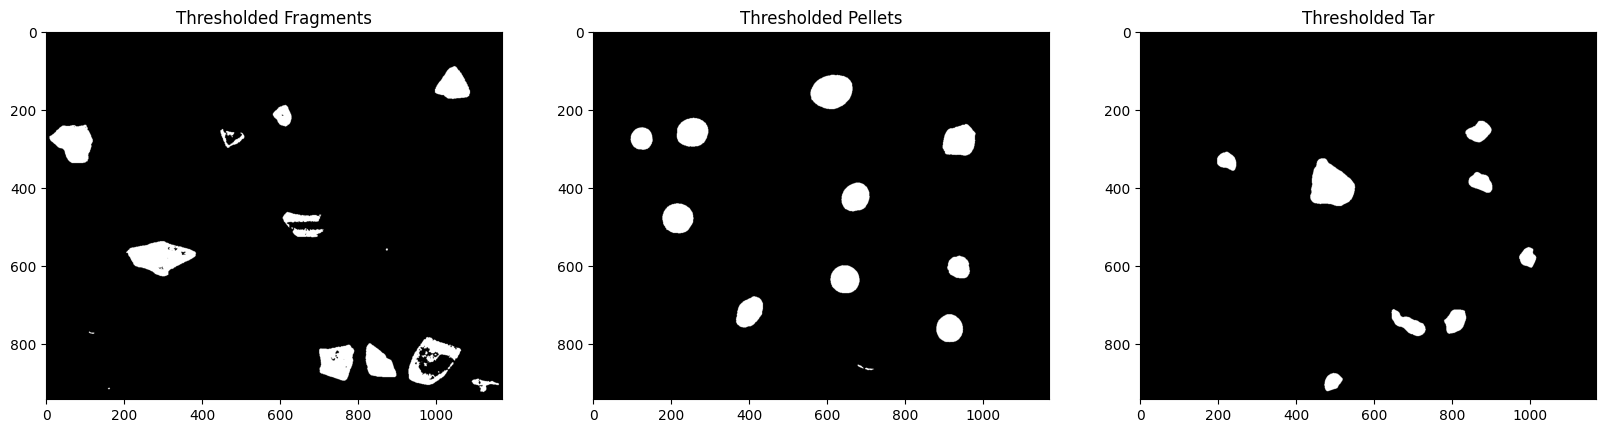

In [195]:
# Apply Otsu's thresholding
_, thresh_fragments = cv2.threshold(blur_fragments, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, thresh_pellets = cv2.threshold(blur_pellets, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, thresh_tar = cv2.threshold(blur_tar, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert images (particles should be white)
thresh_fragments = cv2.bitwise_not(thresh_fragments)
thresh_pellets = cv2.bitwise_not(thresh_pellets)
thresh_tar = cv2.bitwise_not(thresh_tar)

# Print the thresholded and inverted images
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(thresh_fragments, cmap='gray')
plt.title('Thresholded Fragments')
plt.subplot(132)
plt.imshow(thresh_pellets, cmap='gray')
plt.title('Thresholded Pellets')
plt.subplot(133)
plt.imshow(thresh_tar, cmap='gray')
plt.title('Thresholded Tar')
plt.show()

### Morphological Opening:

In [197]:
# Define a kernel for morphological operations
kernel = np.ones((3, 3), np.uint8)

# Apply opening to remove small objects and noise
opening_fragments = cv2.morphologyEx(thresh_fragments, cv2.MORPH_OPEN, kernel, iterations=2)
opening_pellets = cv2.morphologyEx(thresh_pellets, cv2.MORPH_OPEN, kernel, iterations=2)
opening_tar = cv2.morphologyEx(thresh_tar, cv2.MORPH_OPEN, kernel, iterations=2)

### Contour Detection:

In [198]:
# Find contours for each image
contours_fragments, _ = cv2.findContours(opening_fragments, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_pellets, _ = cv2.findContours(opening_pellets, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_tar, _ = cv2.findContours(opening_tar, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [199]:
# Set a minimum area threshold to filter out noise
min_area = 600

# Filter contours based on area
filtered_fragments = [cnt for cnt in contours_fragments if cv2.contourArea(cnt) > min_area]
filtered_pellets = [cnt for cnt in contours_pellets if cv2.contourArea(cnt) > min_area]
filtered_tar = [cnt for cnt in contours_tar if cv2.contourArea(cnt) > min_area]

## Feature Extraction

In [200]:
def extract_features(contour):
    features = {}
    # Area
    area = cv2.contourArea(contour)
    features['area'] = area

    # Perimeter
    perimeter = cv2.arcLength(contour, True)
    features['perimeter'] = perimeter

    # Compactness
    if area != 0:
        compactness = (perimeter ** 2) / area
    else:
        compactness = 0
    features['compactness'] = compactness

    # Bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h != 0 else 0
    features['aspect_ratio'] = aspect_ratio

    # Extent (area ratio)
    rect_area = w * h
    extent = area / rect_area if rect_area != 0 else 0
    features['extent'] = extent

    # Ellipse axes ratio
    if len(contour) >= 5:
        ellipse = cv2.fitEllipse(contour)
        (center, axes, orientation) = ellipse
        major_axis = max(axes)
        minor_axis = min(axes)
        ellipse_axis_ratio = minor_axis / major_axis if major_axis != 0 else 0
        features['ellipse_axis_ratio'] = ellipse_axis_ratio
    else:
        features['ellipse_axis_ratio'] = 0

    return features

In [201]:
# Initialize a list to store data
data = []

# Process fragments
for contour in filtered_fragments:
    features = extract_features(contour)
    features['label'] = 'Fragment'
    data.append(features)

# Process pellets
for contour in filtered_pellets:
    features = extract_features(contour)
    features['label'] = 'Pellet'
    data.append(features)

# Process tar
for contour in filtered_tar:
    features = extract_features(contour)
    features['label'] = 'Tar'
    data.append(features)

# Create a DataFrame
df = pd.DataFrame(data)


     area   perimeter  compactness  aspect_ratio    extent  \
0  6114.5  326.894442    17.476486      0.967391  0.746764   
1  4362.0  279.965510    17.968979      0.918605  0.642037   
2  5545.5  722.256920    94.068174      1.098361  0.339216   
3  9346.0  478.475176    24.495880      1.955556  0.590025   
4  1105.0  189.053823    32.345111      3.619048  0.692356   

   ellipse_axis_ratio     label  
0            0.932738  Fragment  
1            0.527443  Fragment  
2            0.714499  Fragment  
3            0.488717  Fragment  
4            0.236679  Fragment  
              area   perimeter  compactness  aspect_ratio     extent  \
count    27.000000   27.000000    27.000000     27.000000  27.000000   
mean   4024.703704  266.525239    20.387093      1.253003   0.687354   
std    2362.717256  120.155753    15.636805      0.699381   0.101027   
min    1105.000000  149.781745    13.964777      0.843137   0.339216   
25%    2218.000000  190.509666    14.718036      0.962569   0.6

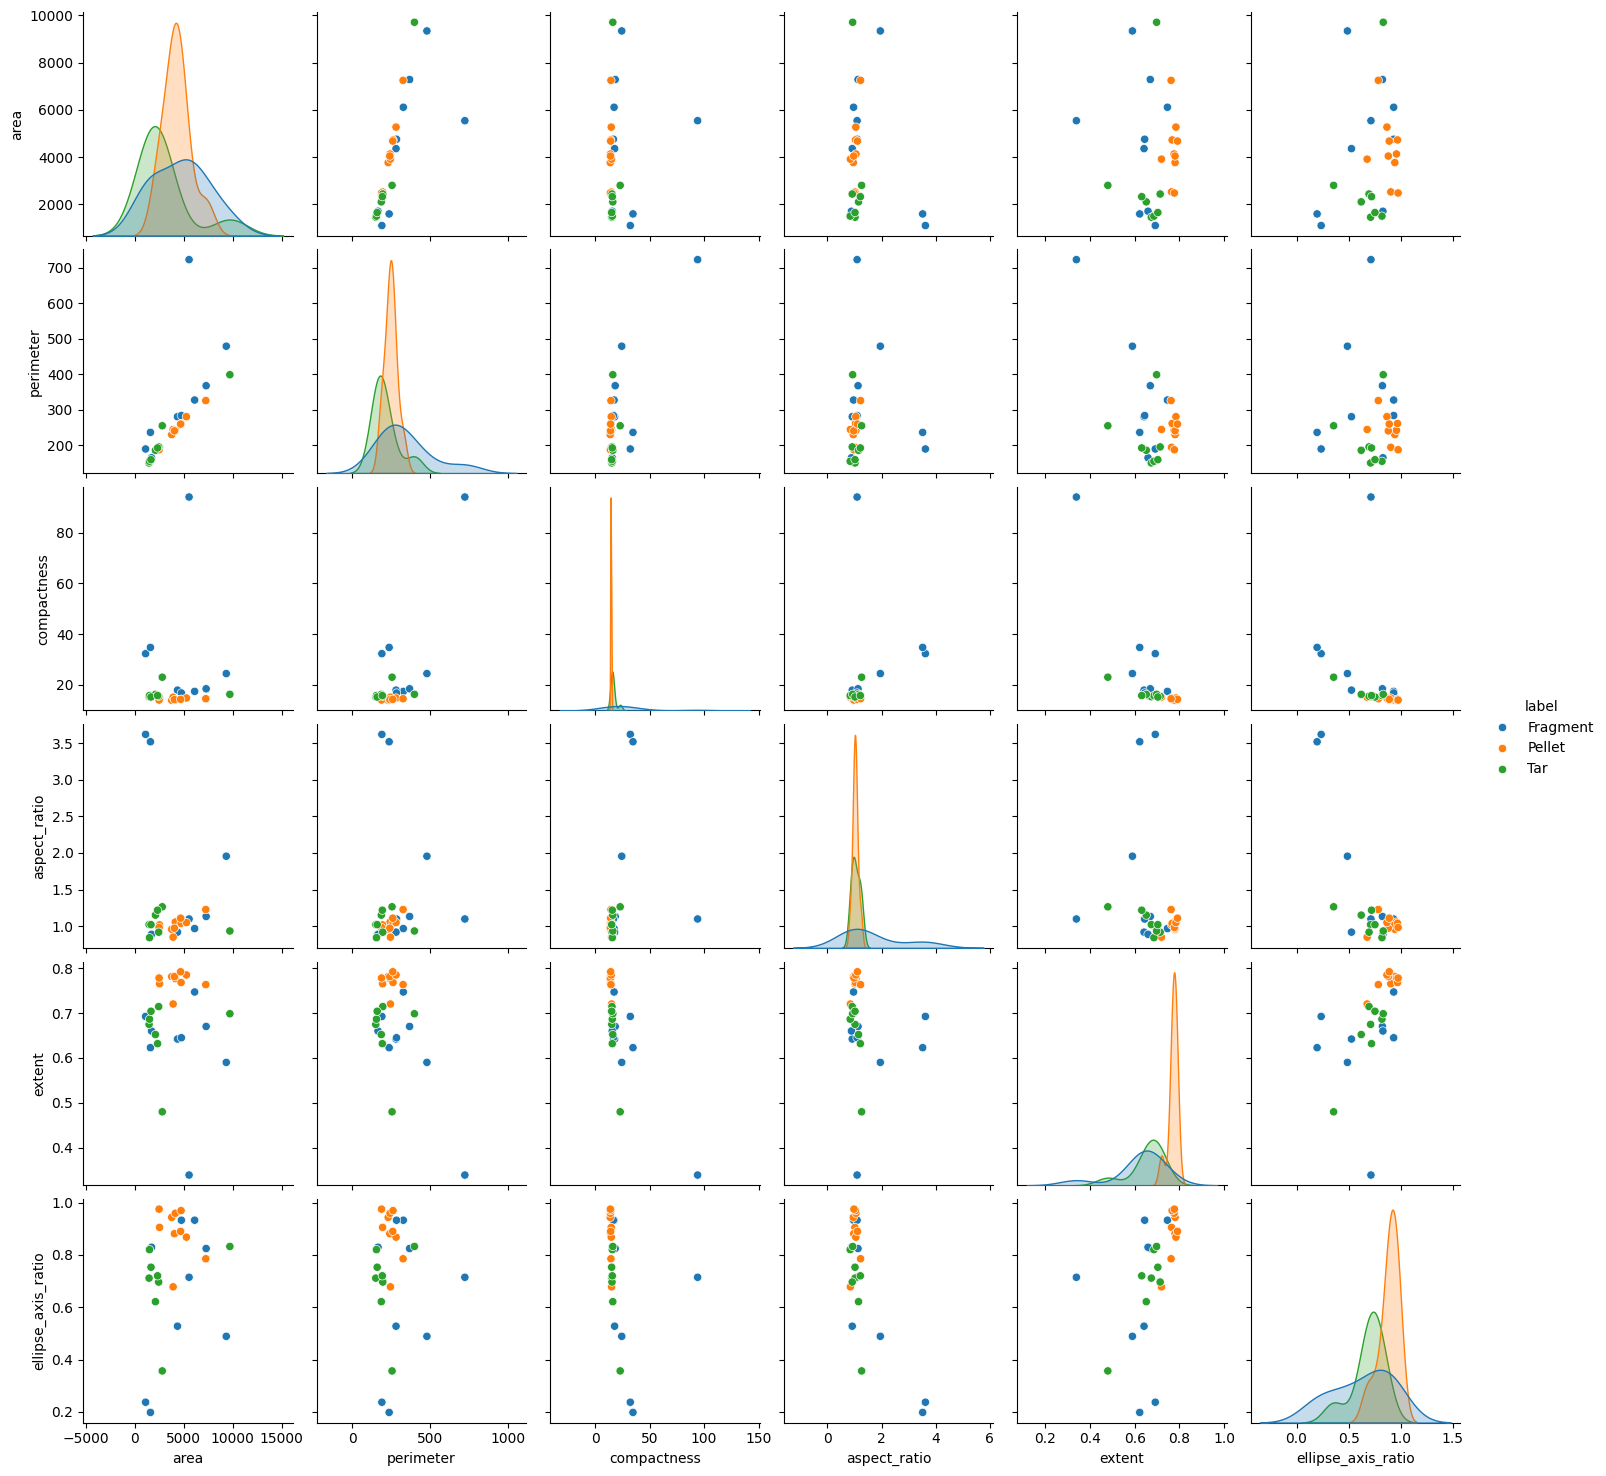

In [202]:
# Display first few rows
print(df.head())

# Statistical summary
print(df.describe())

# Visualize feature distribution
sns.pairplot(df, hue='label')
plt.show()

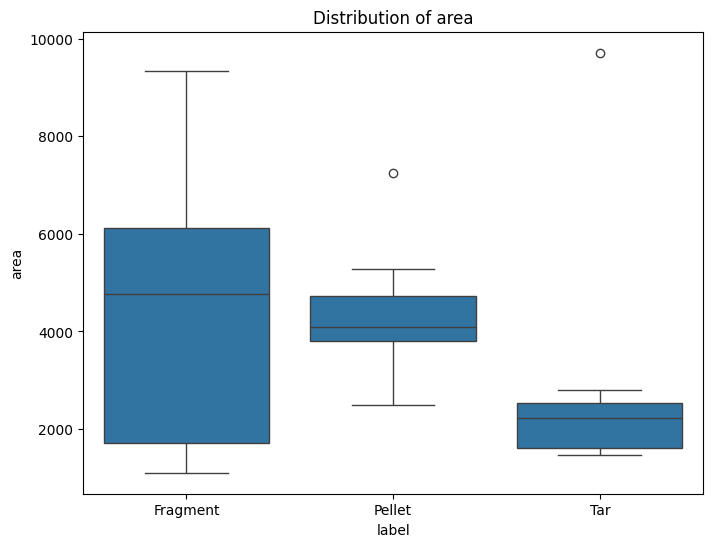

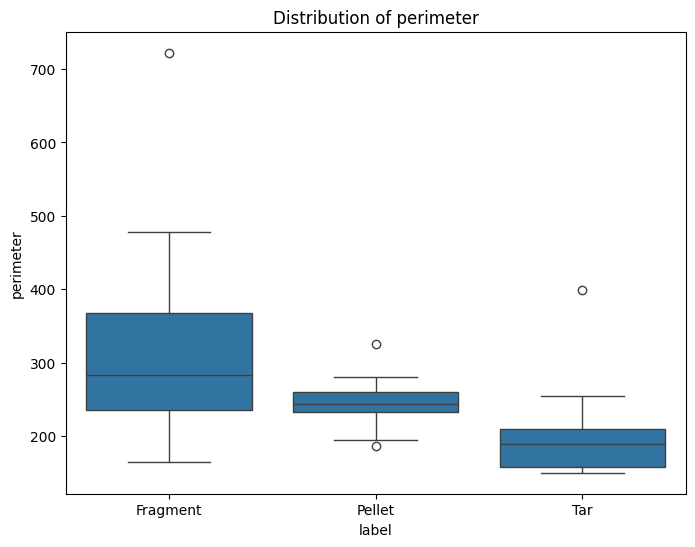

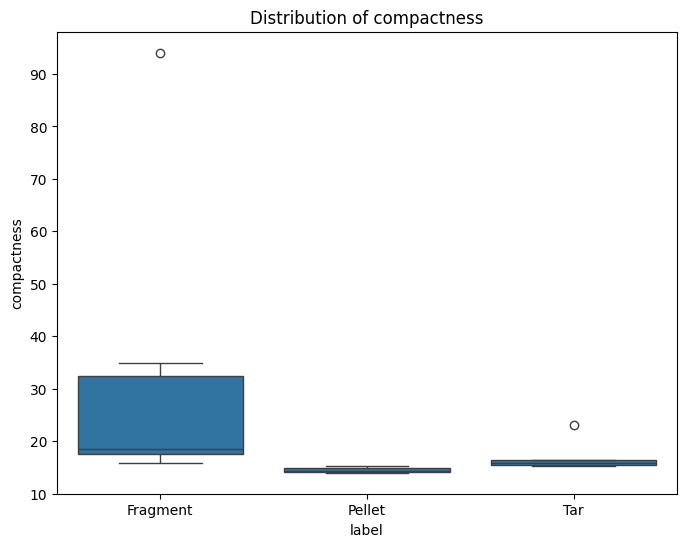

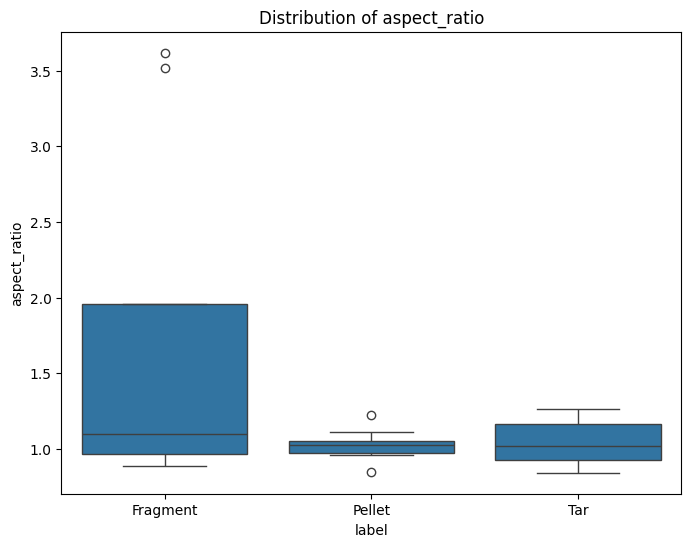

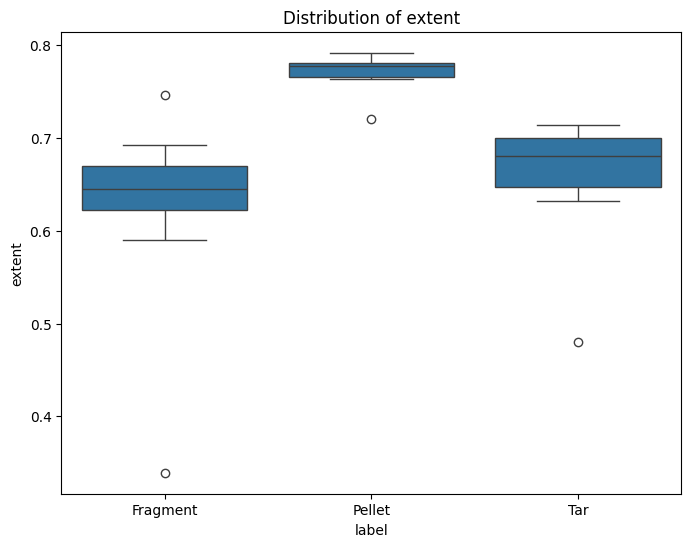

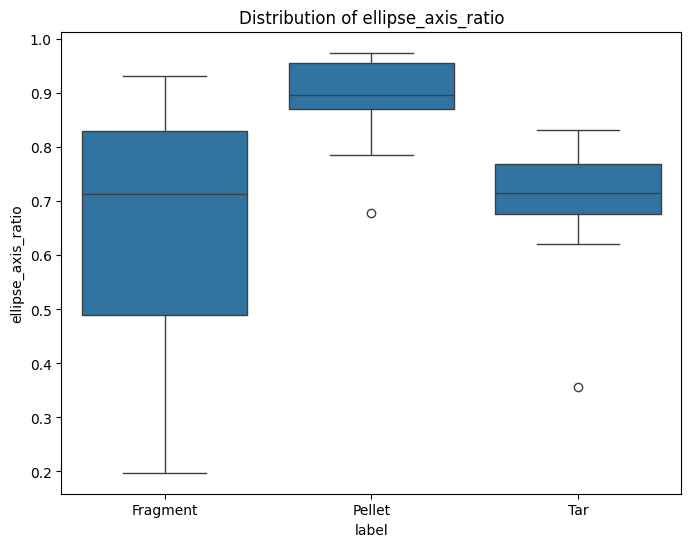

In [203]:
# Boxplots for each feature
features = ['area', 'perimeter', 'compactness', 'aspect_ratio', 'extent', 'ellipse_axis_ratio']

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='label', y=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.show()

In [204]:
# Calculate mean and std per class
grouped = df.groupby('label').agg(['mean', 'std'])
print(grouped)

                 area                perimeter             compactness  \
                 mean          std        mean         std        mean   
label                                                                    
Fragment  4647.722222  2796.956975  338.565966  172.319105   30.253221   
Pellet    4282.250000  1372.428651  246.118706   39.998996   14.462042   
Tar       3001.875000  2753.734228  210.987588   82.698895   16.694012   

                    aspect_ratio              extent            \
                std         mean       std      mean       std   
label                                                            
Fragment  24.930189     1.688509  1.112759  0.623123  0.115201   
Pellet     0.402809     1.026251  0.099786  0.770927  0.020009   
Tar        2.603259     1.046500  0.151039  0.655148  0.075898   

         ellipse_axis_ratio            
                       mean       std  
label                                  
Fragment           0.631584  0.282850 

In [205]:
def classifier(features):
    # Extract feature values
    compactness = features['compactness']
    aspect_ratio = features['aspect_ratio']
    ellipse_axis_ratio = features['ellipse_axis_ratio']
    extent = features['extent']
    
    # Adjusted thresholds based on data
    compactness_fragment_threshold = 21.7  # Mean between Tar and Fragment
    compactness_pellet_threshold = 15.47   # Mean between Pellet and Tar
    ellipse_axis_ratio_pellet_threshold = 0.787  # Mean between Pellet and Tar
    extent_pellet_threshold = 0.714        # Mean between Pellet and Tar
    aspect_ratio_fragment_threshold = 1.27 # Mean between Tar and Fragment
    
    # Classification rules based on adjusted thresholds
    if compactness > compactness_fragment_threshold:
        return 'Fragment'
    elif compactness < compactness_pellet_threshold:
        if ellipse_axis_ratio > ellipse_axis_ratio_pellet_threshold and extent > extent_pellet_threshold:
            return 'Pellet'
        else:
            return 'Tar'
    else:
        if aspect_ratio > aspect_ratio_fragment_threshold:
            return 'Fragment'
        else:
            return 'Tar'


In [210]:
# Apply the classifier to each particle
df['predicted_label'] = df.apply(classifier, axis=1)


In [211]:
from sklearn.metrics import confusion_matrix, classification_report

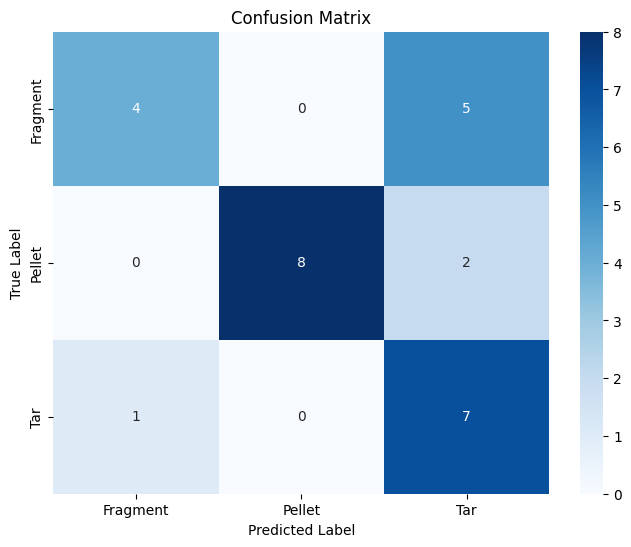

              precision    recall  f1-score   support

    Fragment       0.80      0.44      0.57         9
      Pellet       1.00      0.80      0.89        10
         Tar       0.50      0.88      0.64         8

    accuracy                           0.70        27
   macro avg       0.77      0.71      0.70        27
weighted avg       0.79      0.70      0.71        27



In [212]:
# Actual labels
y_true = df['label']
# Predicted labels
y_pred = df['predicted_label']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['Fragment', 'Pellet', 'Tar'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Fragment', 'Pellet', 'Tar'], yticklabels=['Fragment', 'Pellet', 'Tar'], cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

In [214]:
# Function to classify and visualize particles in an image
def classify_and_visualize_manual(original_img, contours):
    img_output = original_img.copy()
    for contour in contours:
        # Extract features
        features = extract_features(contour)
    
        # Predict the label using manual classifier
        predicted_label = classifier(features)
    
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
    
        # Draw rectangle and label
        cv2.rectangle(img_output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img_output, predicted_label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Convert BGR to RGB for plotting
    img_rgb = cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Classification Results')
    plt.show()


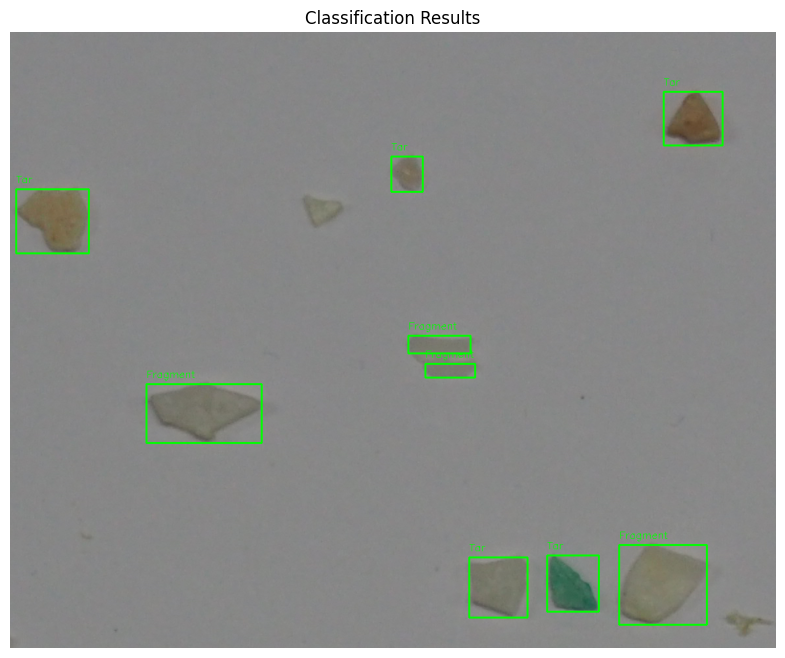

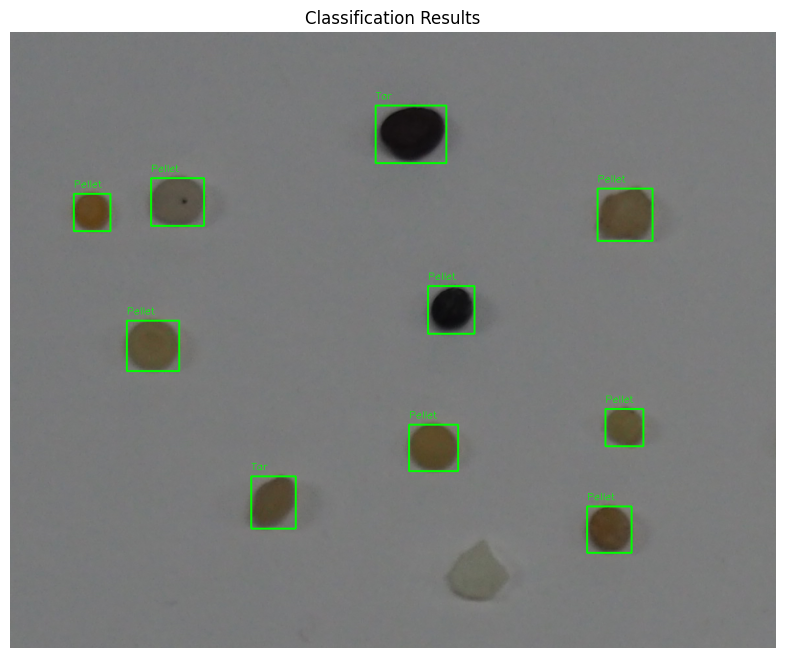

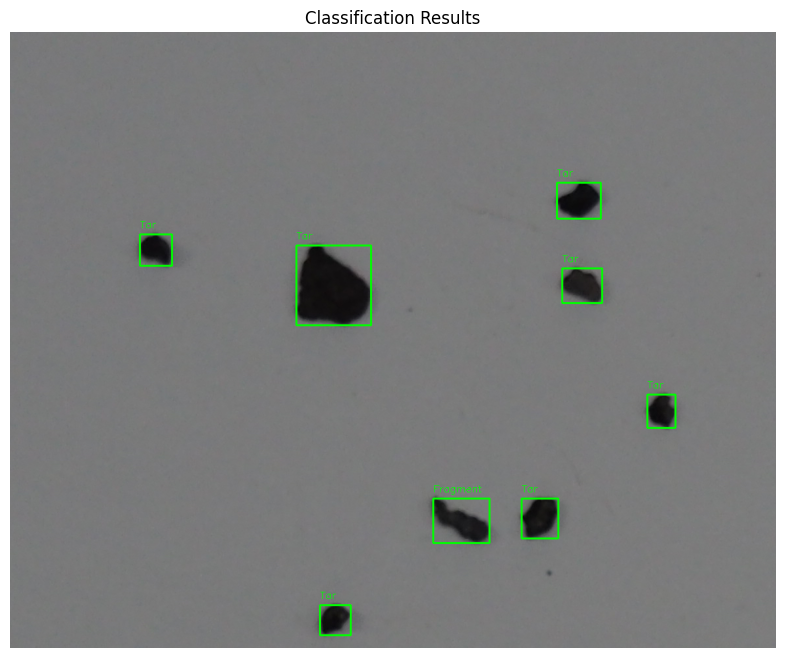

In [215]:
# Visualize results on the fragments image
classify_and_visualize_manual(img_fragments, filtered_fragments)

# Visualize results on the pellets image
classify_and_visualize_manual(img_pellets, filtered_pellets)

# Visualize results on the tar image
classify_and_visualize_manual(img_tar, filtered_tar)
